In [1]:
import math
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline
from pandas.tools.plotting import scatter_matrix
from scipy.spatial.distance import euclidean
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, r2_score, roc_curve, auc, confusion_matrix, f1_score,  silhouette_samples, silhouette_score
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression


# EDA

In [2]:
df = pd.read_csv('Final Project Data_Case.csv')

In [3]:
df.columns = ['age', 'female', 'flu_season', 'ed_admit', 'severity_score', 'comorbidity_score', 'readmit30']

In [4]:
df.head()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,0
3,66,1,1,1,25,4,0
4,68,1,1,1,25,32,0


#### Check for duplicates

In [5]:
df.drop_duplicates(keep='first', inplace=True)

#### Get basic data metrics

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4372 entries, 0 to 4381
Data columns (total 7 columns):
age                  4372 non-null int64
female               4372 non-null int64
flu_season           4372 non-null int64
ed_admit             4372 non-null int64
severity_score       4372 non-null int64
comorbidity_score    4372 non-null int64
readmit30            4372 non-null int64
dtypes: int64(7)
memory usage: 273.2 KB


#### Get data statistical metrics

In [7]:
df.describe()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30
count,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000,4372.000000
mean,76.857045,0.469808,0.407594,0.810156,22.385636,94.770357,0.228042
std,7.905581,0.499145,0.491443,0.392223,18.006505,57.161220,0.419618
min,65.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000
25%,70.000000,0.000000,0.000000,1.000000,8.000000,51.000000,0.000000
50%,76.000000,0.000000,0.000000,1.000000,19.000000,86.000000,0.000000
75%,82.000000,1.000000,1.000000,1.000000,32.000000,131.000000,0.000000
max,105.000000,1.000000,1.000000,1.000000,112.000000,322.000000,1.000000


#### Data correlation matrix

In [8]:
df.corr()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30
age,1.000000,0.149386,-0.011674,0.139991,0.280944,0.161004,0.102519
female,0.149386,1.000000,0.015671,0.121463,0.094204,0.004985,0.041072
flu_season,-0.011674,0.015671,1.000000,-0.011510,0.003563,-0.012630,0.121623
ed_admit,0.139991,0.121463,-0.011510,1.000000,0.333882,0.029148,0.053204
severity_score,0.280944,0.094204,0.003563,0.333882,1.000000,0.196449,0.250117
comorbidity_score,0.161004,0.004985,-0.012630,0.029148,0.196449,1.000000,0.383042
readmit30,0.102519,0.041072,0.121623,0.053204,0.250117,0.383042,1.000000


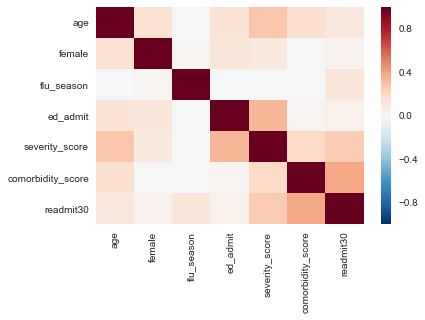

In [9]:
sns.heatmap(df.corr());

#### Data Feature Distribution

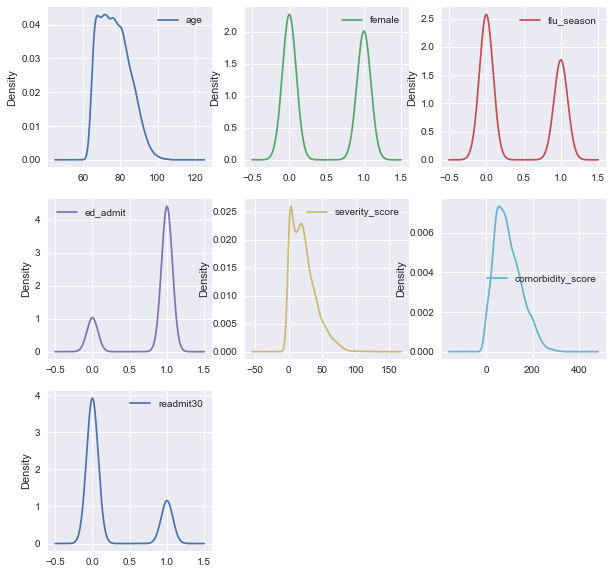

In [10]:
df.plot(kind='density', subplots=True, layout=(3,3), sharex=False, figsize=(10,10));

#### Class Imbalance

In [11]:
df.groupby(df.readmit30).readmit30.count()

readmit30
0    3375
1     997
Name: readmit30, dtype: int64

In [12]:
df.groupby(df.readmit30).readmit30.count()/df.readmit30.count()

readmit30
0    0.771958
1    0.228042
Name: readmit30, dtype: float64

# Machine Learning model for predicting readmit30

#### Dataset Split

In [13]:
dfmodel = df.copy()
y = dfmodel.pop('readmit30')
X = dfmodel
X_train, X_test, y_train, y_test = train_test_split(X,y,random_state=42)

#### Class distribution on y_train

In [14]:
y_train.groupby(y_train).size() / len(y_train)

readmit30
0    0.765477
1    0.234523
Name: readmit30, dtype: float64

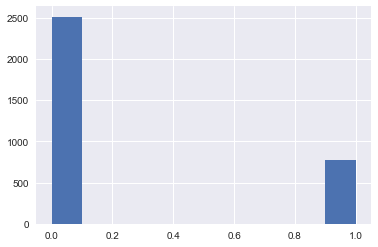

In [15]:
y_train.hist()

#### Class distribution on y_test

In [16]:
y_test.groupby(y_test).size() / len(y_test)

readmit30
0    0.7914
1    0.2086
Name: readmit30, dtype: float64

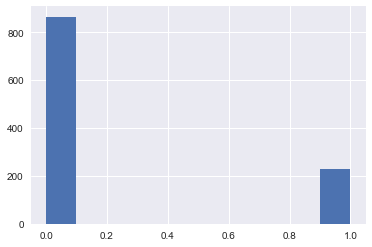

In [17]:
y_test.hist()

#### Visualizing Confusion Matrix  Function

In [18]:
#http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
def show_confusion_matrix(C,class_labels=['0','1'], plot_color='Black', model='Confusion Matrix'):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(10,6))
    plt.title(model, fontdict={'fontsize':16}, loc= 'right')
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.get_cmap(plot_color+'s'))

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], plot_color, lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], plot_color, lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], plot_color, lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], plot_color, lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=14)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=14, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    
    plt.tight_layout()
    plt.show()

## Random Forest

#### Grid Search for parameters

In [19]:
rf_params = {'n_estimators':[i for i in range(100,500,50)],'max_depth':[i for i in range(1,5)]}

In [20]:
rf_grid = GridSearchCV( RandomForestClassifier(),rf_params)

In [21]:
rf_grid.fit(X_train,y_train)

GridSearchCV(cv=None, error_score='raise',
       estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False),
       fit_params={}, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100, 150, 200, 250, 300, 350, 400, 450], 'max_depth': [1, 2, 3, 4]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

#### Get best Model from GridSearch

In [22]:
rf_model = rf_grid.best_estimator_

#### Fit Model on training data

In [23]:
rf_model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

#### Predict on test

In [24]:
rf_predicted = rf_model.predict(X_test)

#### Class distribution on predicted

In [25]:
pd.Series(rf_predicted).groupby(pd.Series(rf_predicted)).size() / len(y_test)

0    0.920403
1    0.079597
dtype: float64

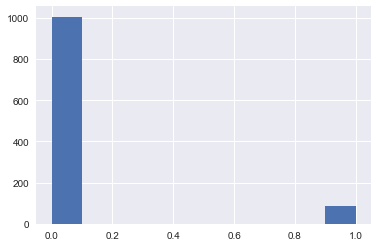

In [26]:
pd.Series(rf_predicted).hist()

#### RF Feature Importance

In [27]:
rf_feature_importance = pd.DataFrame([i for i in zip(dfmodel.columns,rf_model.feature_importances_)], 
                                  columns = ['feature', 'importance'])
rf_feature_importance

,feature,importance
0,age,0.051315
1,female,0.007090
2,flu_season,0.065468
3,ed_admit,0.006845
4,severity_score,0.274338
5,comorbidity_score,0.594944


## Logistic Regression

#### Define model

In [28]:
log_model = LogisticRegression()

#### Fit Model on training data

In [29]:
log_model.fit(X_train, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Predict on test

In [30]:
log_predicted = log_model.predict(X_test)

#### Class distribution on predicted

In [31]:
pd.Series(log_predicted).groupby(pd.Series(log_predicted)).size() / len(y_test)

0    0.880146
1    0.119854
dtype: float64

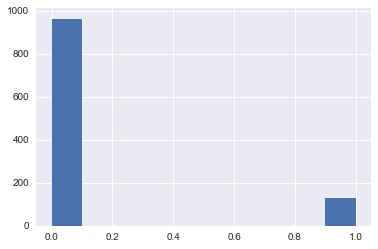

In [32]:
pd.Series(log_predicted).hist()

## Under Sample Class 0

#### Make new datasets

In [33]:
df1 = df[df.readmit30==1]
df0 = df[df.readmit30==0]
# Sample class 0 for size 120% of class 1 
dfsample0 = df0.sample(n=int((120/100)*df1.shape[0]), replace=False, random_state=42) 
# Find class 0 from original df not in sample
dfsample0c = pd.concat([dfsample0, df0]).drop_duplicates(keep=False)
# New balanced dataframe to split
newdf = pd.concat([dfsample0, df1])
df.shape, df0.shape, dfsample0.shape, dfsample0c.shape, df1.shape, newdf.shape

((4372, 7), (3375, 7), (1196, 7), (2179, 7), (997, 7), (2193, 7))

#### New class imbalance

In [34]:
newdf.groupby(newdf.readmit30).readmit30.count() / newdf.shape[0]

readmit30
0    0.545372
1    0.454628
Name: readmit30, dtype: float64

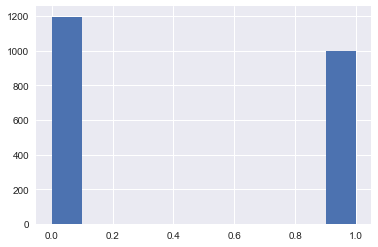

In [35]:
pd.Series(newdf.readmit30).hist()

#### Dataset split

In [36]:
newy = newdf.pop('readmit30')
newX = newdf
newX_train, newX_test, newy_train, newy_test = train_test_split(newX,newy,random_state=42)

In [37]:
len(newy_train) + len(newy_test) + dfsample0c.shape[0], len(newy_test) + dfsample0c.shape[0]

(4372, 2728)

#### Add excluded dfsample0c to the test set

In [38]:
newdftest = pd.concat([dfsample0c, newX_test.join(pd.DataFrame(newy_test))])
newy_test = newdftest.pop('readmit30')
newX_test = newdftest
newdftest.shape

(2728, 6)

## Logistic Regression

#### Define model

In [39]:
newlog_model = LogisticRegression()

#### Fit Model on training data

In [40]:
newlog_model.fit(newX_train, newy_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Predict on test

In [41]:
newlog_predicted = newlog_model.predict(newX_test)

#### Class distribution on predicted

In [42]:
pd.Series(newlog_predicted).groupby(pd.Series(newlog_predicted)).size() / len(newy_test)

0    0.721774
1    0.278226
dtype: float64

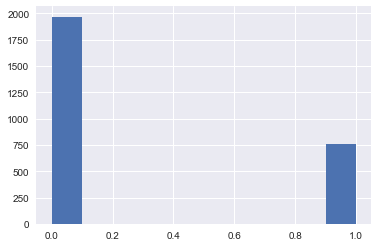

In [43]:
pd.Series(newlog_predicted).hist()

## Clustering

In [44]:
#http://www.awesomestats.in/python-cluster-validation/

In [45]:
cmap = sns.cubehelix_palette(as_cmap=True, rot=-.3, light=1)

/Users/jaichitra.balakrishnan/anaconda3/envs/dl/lib/python3.6/site-packages/matplotlib/cbook.py:136: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


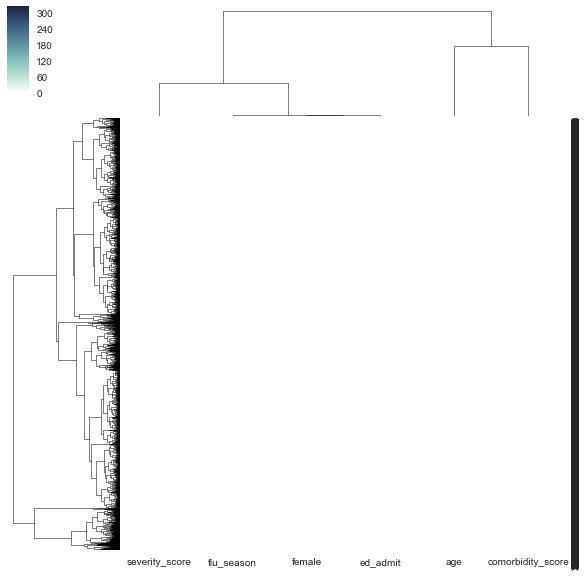

In [46]:
sns.clustermap(X, cmap=cmap, linewidths=.5, figsize=(10, 10))

For n_clusters = 2 the average silhouette_score is : 0.516871400741


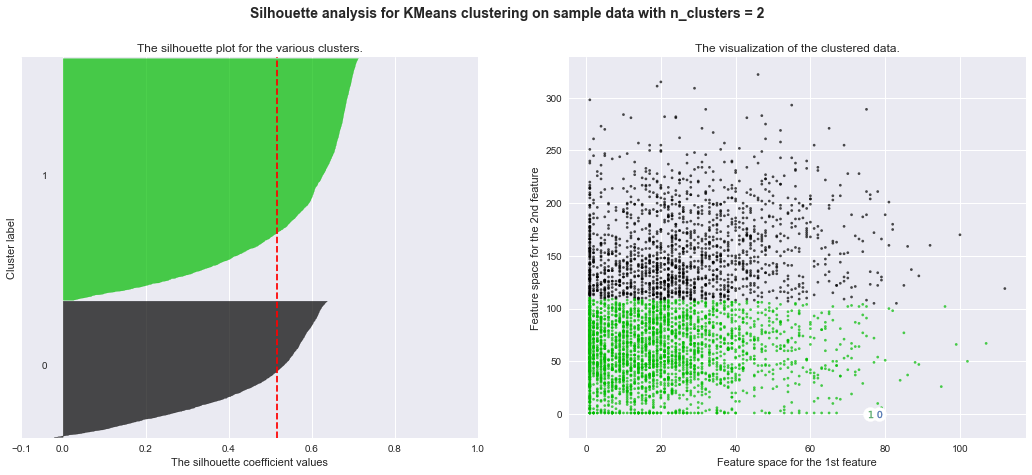

For n_clusters = 3 the average silhouette_score is : 0.423202670638


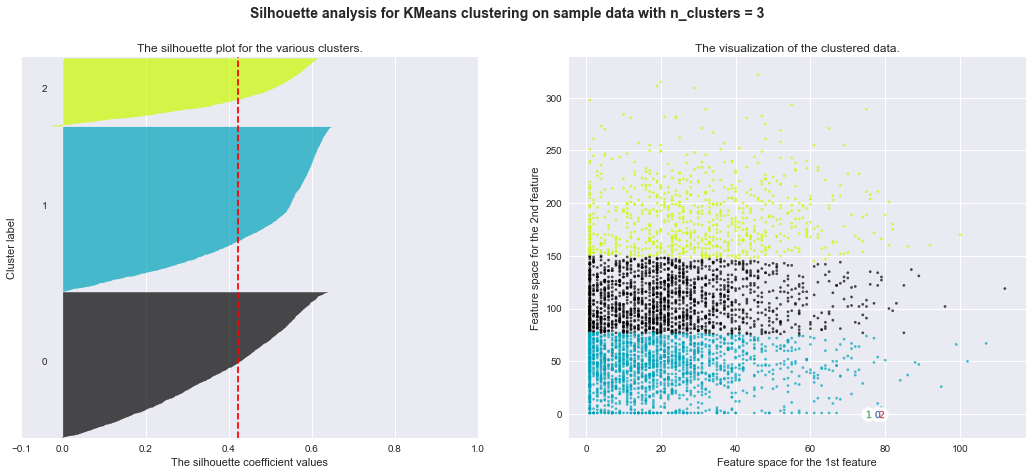

For n_clusters = 4 the average silhouette_score is : 0.368724933611


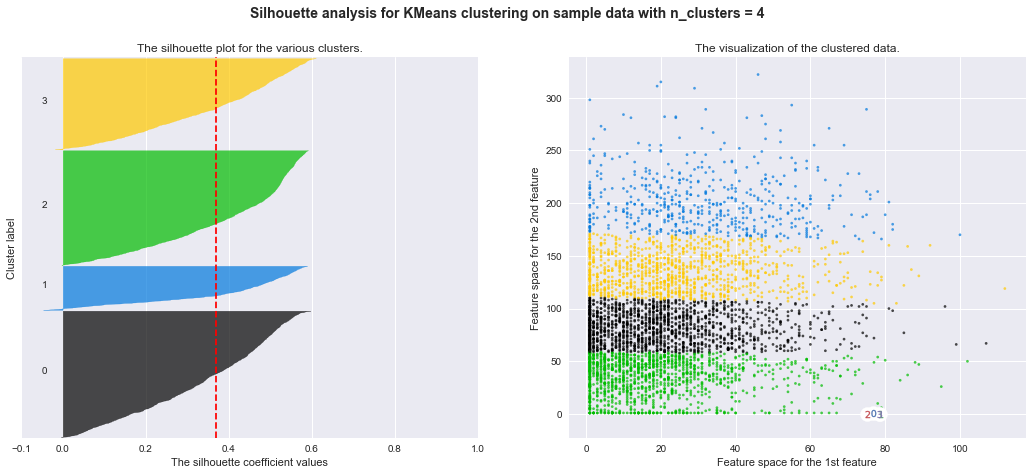

In [47]:
cluster_range = range(2, 5)

for n_clusters in cluster_range:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all lie within [-0.1, 1]
    ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict( X )    

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters, "the average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]
        ith_cluster_silhouette_values.sort()
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, 
                          ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhoutte score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X['severity_score'], X['comorbidity_score'], marker='.', s=30, lw=0, alpha=0.7, c=colors)    

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                "with n_clusters = %d" % n_clusters),
               fontsize=14, fontweight='bold')

    plt.show()

#### Fit and predict cluster numbers from best number of clusters and features

In [48]:
clusterer = KMeans(n_clusters=2, random_state=42)
cluster_labels = clusterer.fit_predict( X )   
X.shape, cluster_labels.shape

((4372, 6), (4372,))

In [49]:
np.unique(cluster_labels), sum(np.isnan(cluster_labels)), np.sum(cluster_labels), cluster_labels.shape[0] - np.sum(cluster_labels)

(array([0, 1], dtype=int32), 0, 2796, 1576)

#### Add cluster number feature to X

In [50]:
cX = pd.concat([X.reset_index(), 
                pd.DataFrame(pd.Series(cluster_labels), columns = ['cluster_number']).reset_index()]
               , axis=1)

In [51]:
np.sum(cX.cluster_number)

2796

In [52]:
cX.head()

,index,age,female,flu_season,ed_admit,severity_score,comorbidity_score,index,cluster_number
0,0,100,1,1,1,38,112,0,0
1,1,83,1,0,1,8,109,1,1
2,2,74,0,1,0,1,80,2,1
3,3,66,1,1,1,25,4,3,1
4,4,68,1,1,1,25,32,4,1


In [53]:
cX = cX.drop([cX.columns[0],cX.columns[7]], axis=1)

In [54]:
cX.head()

,age,female,flu_season,ed_admit,severity_score,comorbidity_score,cluster_number
0,100,1,1,1,38,112,0
1,83,1,0,1,8,109,1
2,74,0,1,0,1,80,1
3,66,1,1,1,25,4,1
4,68,1,1,1,25,32,1


### Logistic Regression

#### Dataset split

In [55]:
cX_train, cX_test, cy_train, cy_test = train_test_split(cX[['age', 'severity_score', 'comorbidity_score', 'cluster_number']],y,random_state=42)

#### Define model

In [56]:
clog_model = LogisticRegression()

#### Fit Model on training data

In [57]:
clog_model.fit(cX_train, cy_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

#### Predict on test

In [58]:
clog_predicted = clog_model.predict(cX_test)

#### Class distribution on predicted

In [59]:
pd.Series(clog_predicted).groupby(pd.Series(clog_predicted)).size() / len(cy_test)

0    0.888381
1    0.111619
dtype: float64

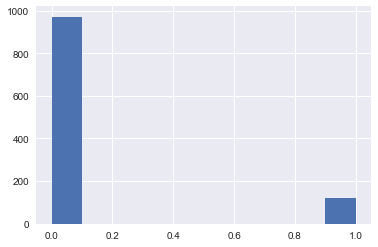

In [60]:
pd.Series(clog_predicted).hist()

#### Metrics for Models

In [61]:
metricsarr = [['Random Forest', abs(accuracy_score(y_test, rf_predicted)),
               abs(r2_score(y_test, rf_predicted)),
               euclidean(y_test, rf_predicted)/math.sqrt(len(y_test)),
               abs(f1_score(y_test, rf_predicted))],
              ['Logistic Regression', abs(accuracy_score(y_test, log_predicted)),
               abs(r2_score(y_test, log_predicted)),
               euclidean(y_test, log_predicted)/math.sqrt(len(y_test)),
               abs(f1_score(y_test, log_predicted))],
              ['Logistic Regression 1', abs(accuracy_score(newy_test, newlog_predicted)),
               abs(r2_score(newy_test, newlog_predicted)),
               euclidean(newy_test, newlog_predicted)/math.sqrt(len(newy_test)),
               abs(f1_score(newy_test, newlog_predicted))],
              ['Logistic Regression 2', abs(accuracy_score(cy_test, clog_predicted)),
               abs(r2_score(cy_test, clog_predicted)),
               euclidean(cy_test, clog_predicted)/math.sqrt(len(cy_test)),
               abs(f1_score(cy_test, clog_predicted))]
             ]
metrics = pd.DataFrame(metricsarr, columns=["model", "accuracy", "r2", "rmse", "f1_score"])  
metrics

,model,accuracy,r2,rmse,f1_score
0,Random Forest,0.814273,0.125033,0.430961,0.355556
1,Logistic Regression,0.816102,0.113949,0.428833,0.440111
2,Logistic Regression 1,0.757331,2.106532,0.492614,0.332661
3,Logistic Regression 2,0.804209,0.185995,0.442483,0.388571


#### Plot ROCs for Models

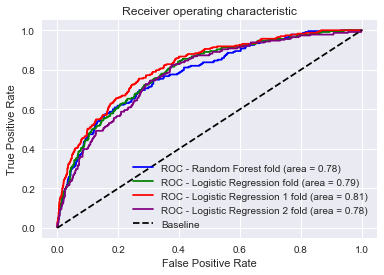

In [62]:
rf_fpr,rf_tpr,rf_threshold = roc_curve(y_test, [_[1] for _ in rf_model.predict_proba(X_test)])
rf_roc_auc = auc(rf_fpr, rf_tpr)
log_fpr,log_tpr,log_threshold = roc_curve(y_test, [_[1] for _ in log_model.predict_proba(X_test)])
log_roc_auc = auc(log_fpr, log_tpr)
newlog_fpr,newlog_tpr,newlog_threshold = roc_curve(newy_test, [_[1] for _ in newlog_model.predict_proba(newX_test)])
newlog_roc_auc = auc(newlog_fpr, newlog_tpr)
clog_fpr,clog_tpr,clog_threshold = roc_curve(cy_test, [_[1] for _ in clog_model.predict_proba(cX_test)])
clog_roc_auc = auc(clog_fpr, clog_tpr)

plt.figure(figsize=(6,4))
plt.plot(rf_fpr, rf_tpr, color='blue', label='ROC - Random Forest fold (area = %0.2f)' % (rf_roc_auc))
plt.plot(log_fpr, log_tpr, color='green', label='ROC - Logistic Regression fold (area = %0.2f)' % (log_roc_auc))
plt.plot(newlog_fpr, newlog_tpr, color='red', label='ROC - Logistic Regression 1 fold (area = %0.2f)' % (newlog_roc_auc))
plt.plot(clog_fpr, clog_tpr, color='purple', label='ROC - Logistic Regression 2 fold (area = %0.2f)' % (clog_roc_auc))
plt.plot([0, 1], [0, 1], linestyle='--', color='k', label = "Baseline")
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc=4)

#### Comparing actual and predictions for models

In [63]:
predicted_df = X_test.join(pd.DataFrame(y_test)).reset_index() \
                  .join(pd.DataFrame(pd.Series(rf_predicted), columns = ['rf_predicted']))\
                  .join(pd.DataFrame(pd.Series(log_predicted), columns = ['log_predicted']))\
                  .join(pd.DataFrame(pd.Series(newlog_predicted), columns = ['newlog_predicted']))\
                  .join(pd.DataFrame(pd.Series(clog_predicted), columns = ['clog_predicted']))
        
                

In [64]:
predicted_df.head()

,index,age,female,flu_season,ed_admit,severity_score,comorbidity_score,readmit30,rf_predicted,log_predicted,newlog_predicted,clog_predicted
0,2019,73,0,0,1,39,44,0,0,0,0,0
1,457,83,0,0,1,44,91,1,0,0,0,0
2,479,85,1,0,1,8,27,0,0,0,0,0
3,438,69,0,0,0,5,53,0,0,0,1,0
4,3736,67,1,0,1,9,36,0,0,0,1,0


#### Confusion matrix for models

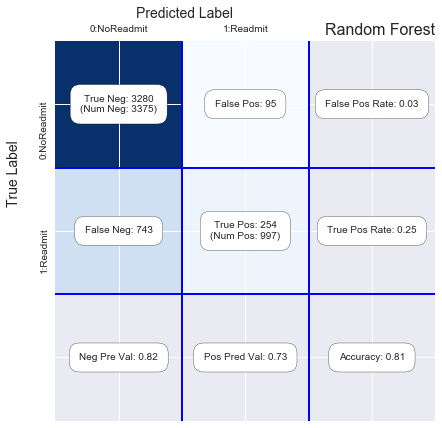

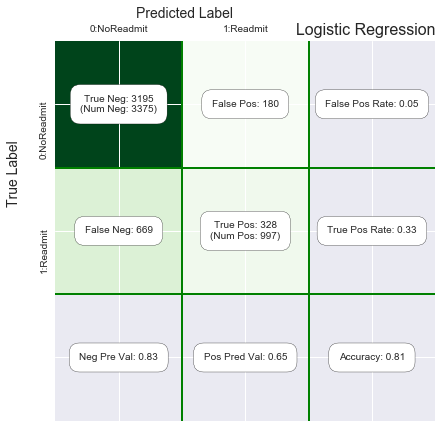

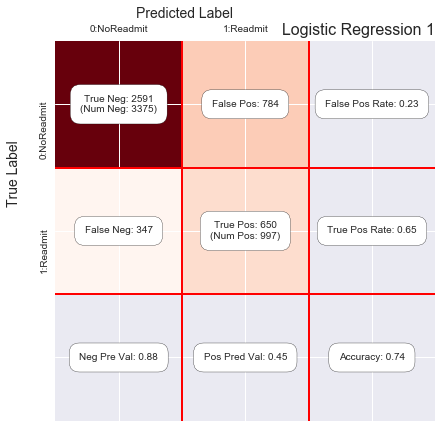

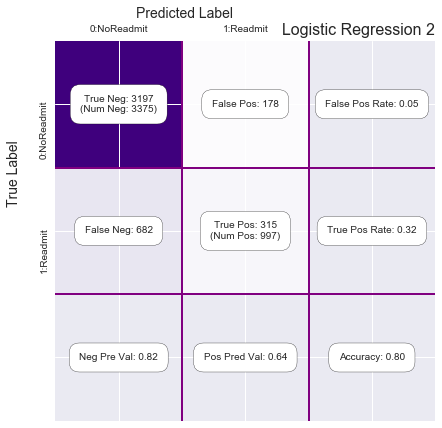

In [65]:
rf_confusion_matrix = confusion_matrix(y , rf_model.predict(X))
log_confusion_matrix = confusion_matrix(y , log_model.predict(X))
newlog_confusion_matrix = confusion_matrix(y , newlog_model.predict(X))
clog_confusion_matrix = confusion_matrix(y , clog_model.predict(cX[['age', 'severity_score', 'comorbidity_score', 'cluster_number']]))
show_confusion_matrix(rf_confusion_matrix,['0:NoReadmit','1:Readmit'], 'Blue', 'Random Forest')
print("\n\n")
show_confusion_matrix(log_confusion_matrix,['0:NoReadmit','1:Readmit'], 'Green', 'Logistic Regression')
print("\n\n")
show_confusion_matrix(newlog_confusion_matrix,['0:NoReadmit','1:Readmit'], 'Red', 'Logistic Regression 1')
print("\n\n")
show_confusion_matrix(clog_confusion_matrix,['0:NoReadmit','1:Readmit'], 'Purple', 'Logistic Regression 2')

In [66]:
num_noreadmit30 = 3384
num_readmit30 = 998
fine_readmit30 = 8000
cost_careprovision = 1200

In [72]:
#Negative : NoReadmit30
#Positive : Readmit30
# tp_cost = Care provision + 60% patients readmit fine
tn_cost = 0 # No readmit fine and no care provision
fp_cost = cost_careprovision # Care provision cost but no readmit fine
fn_cost = fine_readmit30 # Readmit fine but no care provision

rf_tp_num = rf_confusion_matrix[1][1]
rf_tn_num = rf_confusion_matrix[0][0]
rf_fp_num = rf_confusion_matrix[0][1]
rf_fn_num = rf_confusion_matrix[1][0]

log_tp_num = log_confusion_matrix[1][1]
log_tn_num = log_confusion_matrix[0][0]
log_fp_num = log_confusion_matrix[0][1]
log_fn_num = log_confusion_matrix[1][0]

newlog_tp_num = newlog_confusion_matrix[1][1]
newlog_tn_num = newlog_confusion_matrix[0][0]
newlog_fp_num = newlog_confusion_matrix[0][1]
newlog_fn_num = newlog_confusion_matrix[1][0]

clog_tp_num = clog_confusion_matrix[1][1]
clog_tn_num = clog_confusion_matrix[0][0]
clog_fp_num = clog_confusion_matrix[0][1]
clog_fn_num = clog_confusion_matrix[1][0]

In [76]:
tot_no_careprovision = num_readmit30 * fine_readmit30
tot_all_careprovision = (num_noreadmit30+num_readmit30)*cost_careprovision + 0.6*(num_readmit30)*fine_readmit30
tot_rf_careprovision = (rf_tp_num*cost_careprovision)+(int(rf_tp_num*0.6)*fine_readmit30)+(rf_tn_num*tn_cost)+(rf_fp_num*fp_cost)+(rf_fn_num*fn_cost)
tot_log_careprovision = (log_tp_num*cost_careprovision)+(int(log_tp_num*0.6)*fine_readmit30)+(log_tn_num*tn_cost)+(log_fp_num*fp_cost)+(log_fn_num*fn_cost)
tot_newlog_careprovision = (newlog_tp_num*cost_careprovision)+(int(newlog_tp_num*0.6)*fine_readmit30)+(newlog_tn_num*tn_cost)+(newlog_fp_num*fp_cost)+(newlog_fn_num*fn_cost)
tot_clog_careprovision = (clog_tp_num*cost_careprovision)+(int(clog_tp_num*0.6)*fine_readmit30)+(clog_tn_num*tn_cost)+(clog_fp_num*fp_cost)+(clog_fn_num*fn_cost)

In [77]:
pd.DataFrame([["None", tot_no_careprovision], 
              ["All", tot_all_careprovision], 
              ["Random Forest",tot_rf_careprovision],
              ["Logistic Regression",tot_log_careprovision],
              ["Logistic Regression 1",tot_newlog_careprovision],
              ["Logistic Regression 2",tot_clog_careprovision]
             ],
             columns = ["Type of CareTracker Provision", "Cost in $"])

,Type of CareTracker Provision,Cost in $
0,None,7984000.0
1,All,10048800.0
2,Random Forest,7578800.0
3,Logistic Regression,7529600.0
4,Logistic Regression 1,7616800.0
5,Logistic Regression 2,7559600.0


In [75]:
rf_tp_num,cost_careprovision,int(rf_tp_num),fine_readmit30,rf_tn_num,tn_cost,rf_fp_num,fp_cost,rf_fn_num,fn_cost

(254, 1200, 254, 8000, 3280, 0, 95, 1200, 743, 8000)